In [1]:
!ls /kaggle/input/covidxrayimage/Val

COVID-19  Non-COVID  Normal


| Name | Student ID | Task |
|------|------------|------|
|Brijalben Panchal|500224776|DNN model fine tunning|

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense,Dropout, BatchNormalization

2024-06-12 20:30:06.861890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 20:30:06.862001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 20:30:06.989133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
import cv2
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from scipy import ndimage
from tensorflow.keras.utils import to_categorical

In [7]:
from keras.regularizers import l2

In [8]:
from keras import backend as K

In [9]:
import tensorflow as tf

In [10]:
def mask_images(data_dir, target_size=(224, 224)):
    categories = ['COVID-19', 'Non-COVID', 'Normal']
    original_images = []
    masked_images = []
    labels = []

    for category in categories:
        images_files = os.path.join(data_dir, category, 'images')
        masks_files = os.path.join(data_dir, category, 'lung masks')

        for filename in sorted(os.listdir(images_files)):
            img = os.path.join(images_files, filename)
            mask = os.path.join(masks_files, filename)

            img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
            
            img = cv2.resize(img, target_size)
            mask = cv2.resize(mask, target_size)
            img_masked = cv2.bitwise_and(img, img, mask=mask)

            original_images.append(img)
            masked_images.append(img_masked)
            labels.append(categories.index(category))
            
            
    # Convert to NumPy arrays
    original_images = np.array(original_images)
    masked_images = np.array(masked_images)
    
    return original_images, masked_images, labels

In [11]:
# Confusion Matrix and ROC Curve
def plot_confusion_matrix_and_roc_auc(cm, y_true, y_pred, classes = ['COVID-19', 'Non-COVID', 'Normal'], n_classes=3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # confusion matrix
    ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion matrix')
    ax1.set_xticks(np.arange(len(classes)))
    ax1.set_yticks(np.arange(len(classes)))
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax1.text(j, i, format(cm[i, j], fmt),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

    # ROC AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        ax2.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Model Performance
def model_performance(model, X_val, y_val, classes = ['COVID-19', 'Non-COVID', 'Normal']):
    
    # Model evaluation
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # get confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # get auc score
    roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')

    print(classification_report(y_true, y_pred))
    print(f"ROC AUC: {round(roc_auc,3)}")
    
    # Display confusion matrix and roc-auc score
    plot_confusion_matrix_and_roc_auc(conf_matrix, y_val, y_pred_prob, classes=classes, n_classes=len(classes))

In [12]:
data_dir = "/kaggle/input/covidxrayimage/Val"
original_images, masked_images, labels = mask_images(data_dir)

## Pre-processing image with gaussian filter

In [13]:
def preprocess_gaussian_laplace_images(image_array):
    processed_images = []
    for image in image_array:
        processed_image = ndimage.gaussian_laplace(image, sigma=0.495)
        processed_images.append(processed_image)
        
    return np.array(processed_images)

In [14]:
original_gaussian = preprocess_gaussian_laplace_images(original_images)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# First row: 
axs[0].imshow(original_gaussian[labels.index(0)].squeeze(), cmap='gray')
axs[0].set_title('Original COVID-19 Image')
axs[0].axis('off')

# Second row: 
axs[1].imshow(original_gaussian[labels.index(1)].squeeze(), cmap='gray')
axs[1].set_title('Original Non-COVID Image')
axs[1].axis('off')

# Third row: 
axs[2].imshow(original_gaussian[labels.index(2)].squeeze(), cmap='gray')
axs[2].set_title('Original Normal Image')
axs[2].axis('off')

plt.show()

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(original_gaussian, labels, test_size=0.2, random_state=42, stratify=labels)

In [17]:
categories = ['COVID-19', 'Non-COVID', 'Normal']

In [18]:
y_train = to_categorical(y_train, num_classes=len(categories))

In [19]:
y_test = to_categorical(y_test, num_classes=len(categories))

In [20]:
input_shape = X_train.shape[1:]
num_classes = len(categories)

In [88]:
# DNN model
def build_dnn_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(2000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(500, activation='relu'),
        Dense(250, activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    model.summary()
    return model

In [21]:
checkpoint_path = "/kaggle/working/training/model1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5)

# Checkpoint to save best model
best_model_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,monitor='val_loss')

In [91]:
dnn_gaussian_model = build_dnn_model(input_shape, num_classes)
dnn_gaussian_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,shuffle = True, callbacks=[early_stopping,best_model_cb])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │   100,354,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,012,253 (392.96 MB)

 Trainable params: 103,012,253 (392.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
  5/122 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4366 - f1_score: 0.3952 - loss: 2934.9753

W0000 00:00:1718217855.442035     215 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3735 - f1_score: 0.3707 - loss: 1773.6141

W0000 00:00:1718217886.139008     212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718217886.928793     214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/training/model1.weights.h5


W0000 00:00:1718217887.695031     214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 292ms/step - accuracy: 0.3737 - f1_score: 0.3709 - loss: 1764.6162 - val_accuracy: 0.4470 - val_f1_score: 0.3109 - val_loss: 11.3710
Epoch 2/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4584 - f1_score: 0.4569 - loss: 7.6096
Epoch 2: saving model to /kaggle/working/training/model1.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4589 - f1_score: 0.4574 - loss: 7.5695 - val_accuracy: 0.4608 - val_f1_score: 0.4260 - val_loss: 3.4312
Epoch 3/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5441 - f1_score: 0.5388 - loss: 2.4920
Epoch 3: saving model to /kaggle/working/training/model1.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5442 - f1_score: 0.5390 - loss: 2.4838 - val_accuracy: 0.3710 - val_f1_score: 0.3040 - val_loss: 2.8016
Epoch 4/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6084 - f1_score: 0.6073 - loss: 1.2141
Epoch 4: saving model to /kaggle/working/training/model1

In [92]:
dnn_gaussian_model_eva = build_dnn_model(input_shape, num_classes)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2000)           │   100,354,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,012,253 (392.96 MB)

 Trainable params: 103,012,253 (392.96 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
dnn_gaussian_model_eva.load_weights(checkpoint_path)

27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

W0000 00:00:1718218099.303476     212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


W0000 00:00:1718218100.010346     215 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.70      0.71      0.71       381
           1       0.70      0.61      0.65       361
           2       0.65      0.72      0.68       342

    accuracy                           0.68      1084
   macro avg       0.68      0.68      0.68      1084
weighted avg       0.68      0.68      0.68      1084

ROC AUC: 0.85


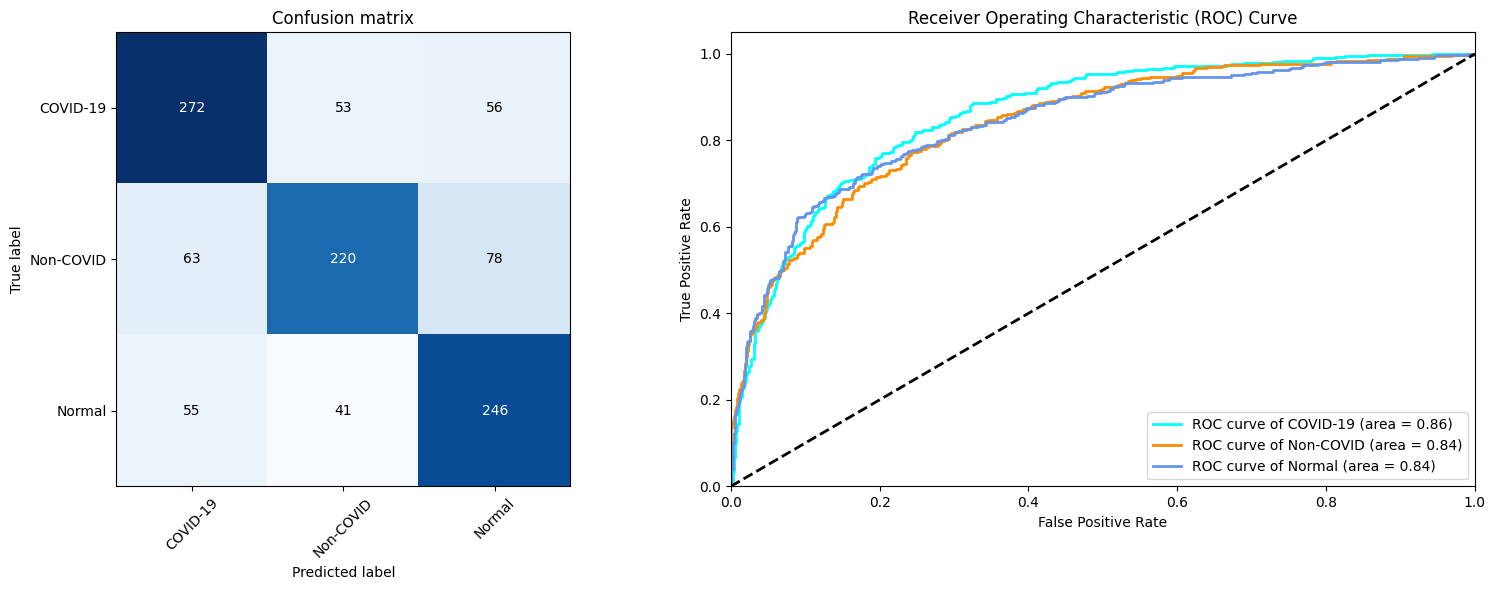

In [94]:
model_performance(dnn_gaussian_model_eva,X_test,y_test)

In [87]:
del dnn_gaussian_model
K.clear_session()

In [110]:
K.clear_session()

In [23]:
def build_dnn_model2(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(2000, activation='relu'),
        Dropout(0.1),
        Dense(1000, activation='relu'),
        Dropout(0.01),
        Dense(500, activation='relu'),
        Dense(250, activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])
    model.summary()
    return model

In [24]:
dnn_model2 = build_dnn_model2(input_shape, num_classes)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │   100,354,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,012,253 (392.96 MB)

 Trainable params: 103,012,253 (392.96 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
dnn_model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,shuffle = True, callbacks=[early_stopping,best_model_cb])

Epoch 1/100
  4/122 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4408 - f1_score: 0.3581 - loss: 1128.7104

I0000 00:00:1718224378.977042     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718224378.994493     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3752 - f1_score: 0.3715 - loss: 1517.3193

W0000 00:00:1718224412.954510     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718224413.780366     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/training/model1.weights.h5


W0000 00:00:1718224414.681315     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.3754 - f1_score: 0.3717 - loss: 1509.4099 - val_accuracy: 0.3433 - val_f1_score: 0.2576 - val_loss: 14.6042
Epoch 2/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4703 - f1_score: 0.4676 - loss: 9.2437
Epoch 2: saving model to /kaggle/working/training/model1.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4704 - f1_score: 0.4677 - loss: 9.2096 - val_accuracy: 0.6521 - val_f1_score: 0.6450 - val_loss: 1.4233
Epoch 3/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5008 - f1_score: 0.4993 - loss: 3.5501
Epoch 3: saving model to /kaggle/working/training/model1.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5008 - f1_score: 0.4994 - loss: 3.5399 - val_accuracy: 0.5346 - val_f1_score: 0.4359 - val_loss: 1.8235
Epoch 4/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5141 - f1_score: 0.5100 - loss: 1.8163
Epoch 4: saving model to /kaggle/working/training/model1.

In [26]:
del dnn_model2
K.clear_session()

In [27]:
dnn_gaussian_model_eva = build_dnn_model2(input_shape, num_classes)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │   100,354,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,012,253 (392.96 MB)

 Trainable params: 103,012,253 (392.96 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
dnn_gaussian_model_eva.load_weights(checkpoint_path)

In [ ]:
model_performance(dnn_gaussian_model_eva,X_test,y_test)

28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

W0000 00:00:1718224530.045107     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


W0000 00:00:1718224530.888815     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.55      0.87      0.67       381
           1       0.55      0.59      0.57       361
           2       0.81      0.22      0.34       342

    accuracy                           0.57      1084
   macro avg       0.64      0.56      0.53      1084
weighted avg       0.63      0.57      0.54      1084

ROC AUC: 0.784


In [30]:
 y_pred_prob = dnn_gaussian_model_eva.predict(X_test)
 y_pred = np.argmax(y_pred_prob, axis=1)
 y_true = np.argmax(y_test, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [31]:
pred_normal_index = np.where(y_pred == 2)
true_covid_19_index = np.where(y_true == 0)

In [32]:
detected_normal_actually_covid_index = np.intersect1d(pred_normal_index, true_covid_19_index)

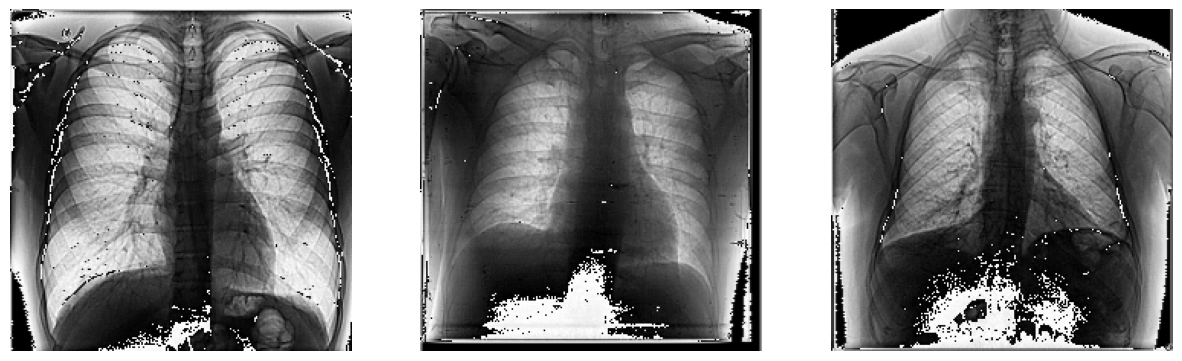

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# First row: 
axs[0].imshow(X_test[detected_normal_actually_covid_index[0]].squeeze(), cmap='gray')
axs[0].axis('off')

# Second row: 
axs[1].imshow(X_test[detected_normal_actually_covid_index[1]].squeeze(), cmap='gray')
axs[1].axis('off')

# Third row: 
axs[2].imshow(X_test[detected_normal_actually_covid_index[2]].squeeze(), cmap='gray')
axs[2].axis('off')

plt.show()

In [34]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb

In [35]:
explainer = lime_image.LimeImageExplainer()

In [40]:
# Define a function to preprocess the input prediction
def predict_fn(images):
    images = np.array(images)
    return dnn_gaussian_model_eva.predict(images)

In [45]:
images = X_test[detected_normal_actually_covid_index]

In [46]:
# Explain the image prediction using the felzenszwalb segmentation algorithm
explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, num_samples=1000,
                                         segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50))

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=uint8)
  • training=False
  • mask=None

In [47]:
del dnn_gaussian_model_eva
K.clear_session()

adding data augmentation by zooming the image

In [73]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    )

In [51]:
def preprocess_gaussian_laplace_images(image_array):
    processed_images = []
    for image in image_array:
        processed_image = ndimage.gaussian_laplace(image, sigma=0.495)
        if len(processed_image.shape) == 2:  # Check if the image is 2D
            processed_image = np.expand_dims(processed_image, axis=-1)  # Expand dimensions if necessary
        processed_images.append(processed_image)
        
    return np.array(processed_images)

In [52]:
original_laplace_gaussian = preprocess_gaussian_laplace_images(original_images)

In [74]:
X_train, X_temp, y_train, y_temp = train_test_split(original_laplace_gaussian, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [75]:
input_shape = X_train.shape[1:]
num_classes = len(categories)

In [76]:
dnn_gaussian_model3 = build_dnn_model2(input_shape, num_classes)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2000)           │   100,354,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,012,253 (392.96 MB)

 Trainable params: 103,012,253 (392.96 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 10,zoom_range = 0.2, horizontal_flip = True,fill_mode='nearest')

In [78]:
datagen.fit(X_train)

In [79]:
from sklearn.utils.class_weight import compute_class_weight

In [80]:
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

In [81]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_flat), y=y_train_flat)

# Convert to a dictionary format required by Keras
class_weights = dict(enumerate(class_weights))

In [82]:
dnn_gaussian_model3.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping,best_model_cb])

Epoch 1/50
  3/136 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2587 - f1_score: 0.2371 - loss: 522.9216

W0000 00:00:1718226635.495017     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/136 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.3244 - f1_score: 0.3219 - loss: 1679.8000

W0000 00:00:1718226649.946269     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3498 - f1_score: 0.3488 - loss: 1004.7224

W0000 00:00:1718226659.146047     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/training/model1.weights.h5


W0000 00:00:1718226659.563180     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.3503 - f1_score: 0.3494 - loss: 995.4600 - val_accuracy: 0.4742 - val_f1_score: 0.4425 - val_loss: 2.5002
Epoch 2/50
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4417 - f1_score: 0.4415 - loss: 3.4806
Epoch 2: saving model to /kaggle/working/training/model1.weights.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.4417 - f1_score: 0.4415 - loss: 3.4726 - val_accuracy: 0.5277 - val_f1_score: 0.5202 - val_loss: 1.2679
Epoch 3/50
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4627 - f1_score: 0.4611 - loss: 1.7039
Epoch 3: saving model to /kaggle/working/training/model1.weights.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.4629 - f1_score: 0.4613 - loss: 1.7007 - val_accuracy: 0.5092 - val_f1_score: 0.5013 - val_loss: 1.1246
Epoch 4/50
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4779 - f1_score: 0.4743 - loss: 1.2139
Epoch 4: saving model to /kaggle/working/training/model

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

W0000 00:00:1718226838.106619     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


W0000 00:00:1718226838.403624     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.53      0.54      0.54       191
           1       0.56      0.68      0.61       180
           2       0.63      0.47      0.54       171

    accuracy                           0.56       542
   macro avg       0.57      0.56      0.56       542
weighted avg       0.57      0.56      0.56       542

ROC AUC: 0.751


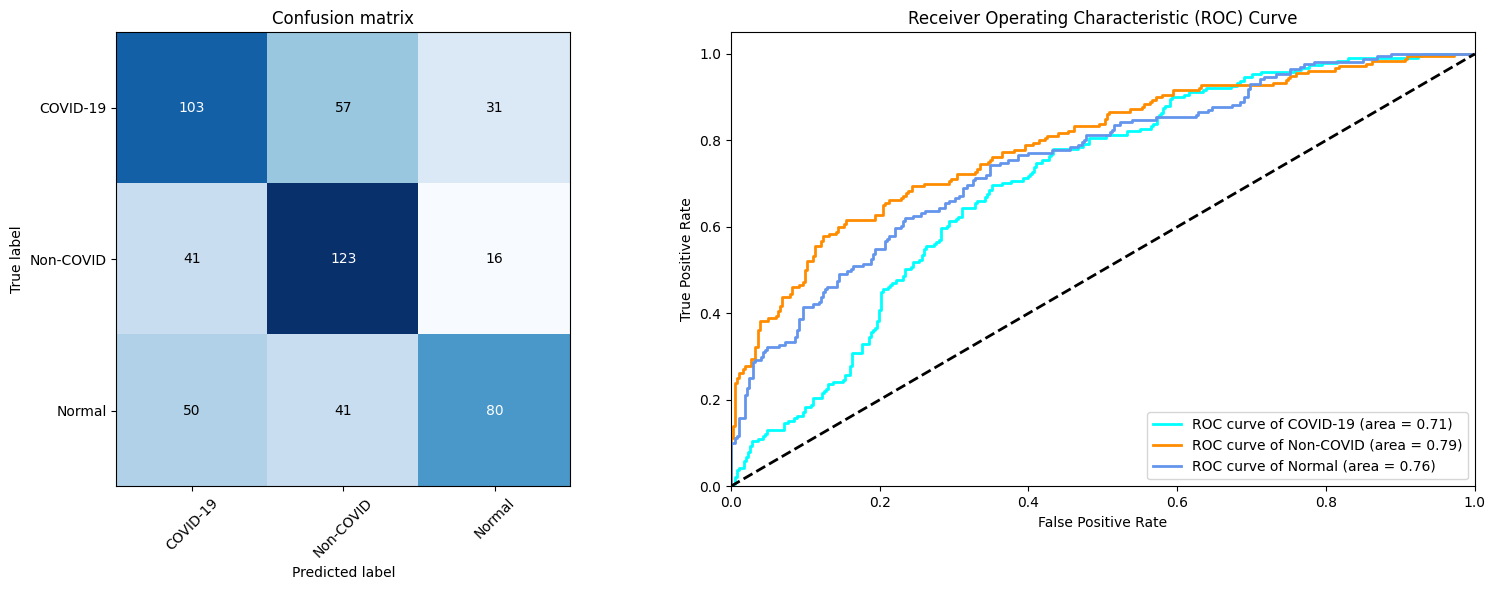

In [83]:
model_performance(dnn_gaussian_model3,X_test,y_test)

In [86]:
del dnn_gaussian_model3
K.clear_session()

From Model performance we can see the accuracy has been drop with fine tuning by adding augmentation and drop in the model